<a href="https://colab.research.google.com/github/musicjae/NLP/blob/master/gpt2/gpt2_LM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [2]:
import os

import numpy as np
import tensorflow as tf

!pip install mxnet
import mxnet

!pip install sentencepiece 
import sentencepiece

!pip install gluonnlp
!pip install transformers
import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
from transformers import TFGPT2LMHeadModel

from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import sent_tokenize

import pandas as pd

     |████████████████████████████████| 38.7MB 80kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 1.2MB 10.3MB/s 
     |████████████████████████████████| 348kB 10.0MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595679 sha256=0bd30d04e0b7538a1fad519a78b947a7829c80ed9990a17ded604d01d17669f9
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 2.0MB 10.7MB/s 
     |████████████████████████████████| 3.2MB 37.7MB/s 
     |████████████████████████████████| 890kB 42.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=d8ca218752c30f0e65a59b5466ec40456df7d868566c9a2c11f6bf34ec8a43e3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a5

In [3]:
!pip install wget
import wget
import zipfile

wget.download('https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/releases/download/v1.0/gpt_ckpt.zip')

with zipfile.ZipFile('gpt_ckpt.zip') as z:
    z.extractall()

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=7aedec0a4addb7fa2164fca8aa623c4c48a47987f9515b77308011137e7aa8df
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


# Model

In [4]:
class GPT2Model(tf.keras.Model):
    def __init__(self, dir_path):
        super(GPT2Model, self).__init__()
        self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)
        
    def call(self, inputs):
        return self.gpt2(inputs)[0]

In [5]:
BASE_MODEL_PATH = './gpt_ckpt'
gpt_model = GPT2Model(BASE_MODEL_PATH)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at ./gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [11]:
BATCH_SIZE = 2
NUM_EPOCHS = 10
MAX_LEN = 600
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token=None,
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [48]:
def tf_top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-99999):
    _logits = logits.numpy()
    top_k = min(top_k, logits.shape[-1])  
    if top_k > 0:
        indices_to_remove = logits < tf.math.top_k(logits, top_k)[0][..., -1, None]
        _logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits = tf.sort(logits, direction='DESCENDING')
        sorted_indices = tf.argsort(logits, direction='DESCENDING')
        cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)

        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove = tf.concat([[False], sorted_indices_to_remove[..., :-1]], axis=0)
        indices_to_remove = sorted_indices[sorted_indices_to_remove].numpy().tolist()
        
        _logits[indices_to_remove] = filter_value
    return tf.constant([_logits])


def generate_sent(seed_word, model, max_step=256, greedy=False, top_k=0, top_p=0.):
    sent = seed_word
    toked = tokenizer(sent)
    
    for _ in range(max_step):
        input_ids = tf.constant([vocab[vocab.bos_token],]  + vocab[toked])[None, :] 
        outputs = model(input_ids)[:, -1, :]
        if greedy:
            gen = vocab.to_tokens(tf.argmax(outputs, axis=-1).numpy().tolist()[0])
        else:
            output_logit = tf_top_k_top_p_filtering(outputs[0], top_k=top_k, top_p=top_p)
            gen = vocab.to_tokens(tf.random.categorical(output_logit, 1).numpy().tolist()[0])[0]
        if gen == '</s>':
            break
        sent += gen.replace('▁', ' ')
        toked = tokenizer(sent)

    return sent

In [13]:
generate_sent('고양이랑 집을', gpt_model, greedy=True)

'고양이랑 집을 옮겼는데'

In [14]:
generate_sent('고양이랑 집을', gpt_model, top_k=0, top_p=0.95)

'고양이랑 집을 옮겼는데 그쪽 아이뿌것인 계림이가  내가  온다'

In [49]:
dir='/content/drive/MyDrive/Colab_Notebooks/JJY/일기 생성/dataset/diary/20210305_blog_daily.tsv'
df = pd.read_csv(dir,sep='\t')
import re

def cleansing(df):
    for i,sen in enumerate(df.contents):
        sen = sen.replace('#다이어트 #다이어터 #유지어터 #다이어트일기 #식단일기 #체중기록 #육아일기 #육아일상 #욘둥이의하루','')
        sen = sen.replace('🧸','')
        sen = sen.replace('✨','')
        sen = sen.replace('이오니 생후','')
        sen = sen.replace('#','')
        sen = sen.replace('육아일기 기록은','')
        sen = sen.replace('💛','')
        sen = sen.replace('💖','')

        df.contents[i] = sen

    return df

data = cleansing(df).contents
sents = [s[:-1] for s in data]
sents

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


['   277일   276일잘잔듯 잘못잔 그런 하루 그래도 오랜만에 침대에서 잔게 뭐라구 이렇게 몸이 가벼운 기분(?)인지 모르게따 (정말 기분만 가벼움 따흑)아침부터 사고칠 준비 하는 이오니 아조그냥 역방쿠 밟고 올라가서 까치발까지 들고 꼼지락 꼼지락리모컨 득템! 아니 그게 거기 있는게 보여? 어떻게 아는거야? 냄새로 아나? 싶을 정도로 잘 찾아내는 것팅팅 부어가지고 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 머리는 까치집을해서는 그렇게 쳐다보면 그래.. 잠깐 가지고 놀아바라.. 하겠지 모요놈 쥐쥐방구 내 머리위에 있는게 분명해다덜 시서스시서스 하길래 머선 브랜드인줄 알았는데 다이어트 보조제 원료? 그런건가부다 후, 만년다이어터 라고 하면서 이제 이런것도 모르고 말야 타이틀 내려놔야겐네으악! 이렇게 작다니! 세상에! 이런걸 보고 자꾸 신생아때가 그리우면 둘째 낳을 때 라던데 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 난 그럼 매년 출산각인가 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ(입조심 말조심 퉤퉤퉤)남은 닭볶음탕에 햄넣고 우동사리넣고 아침부터 밥한그릇 든든하게 뚝딱! 안먹고 싶은데 자꾸 먹으라고 차려주니까 같이 안아 먹게 된당보는것만으로도 기분이 좋은 소소한운세잘자라 우리아가 그나저나 3월부터 쪽쪽이 떼야지 했는데 역시, 쉽지 않군ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 내가 먼저 마음을 단디 먹어야하는데 이미 잊은지 오래.. 크허허..이오니 손구락 마시쩌?치명치명 박치명씨 맘마 한그릇 뚝딱 싹싹 긁어 해치우는거 보면 얼마나 예쁘게요?옆에서 천혜향까는 아빠 덕분에 한조각 맛도 보고요 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 어우 셔ㅋㅋㅋㅋㅋㅋㅋㅋㅋ 표정 진짜 살아있네 살아있어!시다고 침 줄줄 흘리면서도 맛있다고 와구와구 왕왕과일도 자주 챙겨줘야하는데 내가 안먹으니까 아가도 잘 안챙겨주게 되넴.. 미앙..엄마가 더 노력해볼게?야곰야곰 자라나는 자라나라 잔디잔디!천혜향에 너무 진심인데?이건 뭐 거의 과즙망 손잡이까지 다 씹어잡술 기세............... ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ

In [39]:
input_data = []
output_data = []

for s in sents:
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(s)] + [vocab[vocab.eos_token],]
    input_data.append(tokens[:-1])
    output_data.append(tokens[1:])

input_data = pad_sequences(input_data, MAX_LEN, value=vocab[vocab.padding_token])
output_data = pad_sequences(output_data, MAX_LEN, value=vocab[vocab.padding_token])

input_data = np.array(input_data, dtype=np.int64)
output_data = np.array(output_data, dtype=np.int64)

In [40]:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [41]:
gpt_model.compile(loss=loss_function,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[accuracy_function])

In [42]:
history = gpt_model.fit(input_data, output_data, 
                    batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=0.1)

Epoch 1/10
68/68 [==============================] - 75s 846ms/step - loss: 3.9303 - accuracy_function: 0.3167 - val_loss: 2.9806 - val_accuracy_function: 0.3678
Epoch 2/10
68/68 [==============================] - 55s 803ms/step - loss: 2.9615 - accuracy_function: 0.3796 - val_loss: 2.5752 - val_accuracy_function: 0.4004
Epoch 3/10
68/68 [==============================] - 55s 804ms/step - loss: 2.6623 - accuracy_function: 0.4081 - val_loss: 2.3241 - val_accuracy_function: 0.4234
Epoch 4/10
68/68 [==============================] - 55s 804ms/step - loss: 2.4421 - accuracy_function: 0.4295 - val_loss: 2.0603 - val_accuracy_function: 0.4423
Epoch 5/10
68/68 [==============================] - 55s 804ms/step - loss: 2.2938 - accuracy_function: 0.4473 - val_loss: 1.8373 - val_accuracy_function: 0.4595
Epoch 6/10
68/68 [==============================] - 55s 804ms/step - loss: 2.0812 - accuracy_function: 0.4646 - val_loss: 1.6407 - val_accuracy_function: 0.4756
Epoch 7/10
68/68 [================

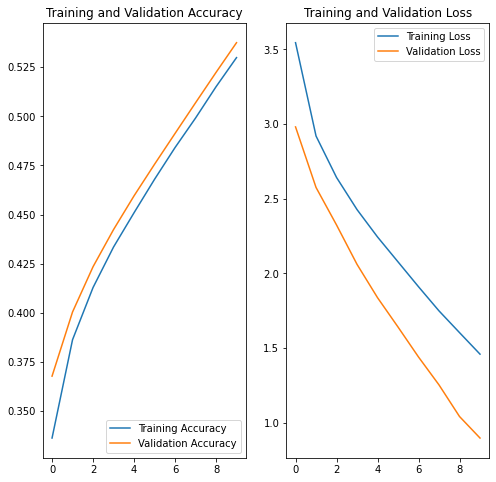

In [44]:
import matplotlib.pyplot as plt

acc = history.history['accuracy_function']
val_acc = history.history['val_accuracy_function']

loss= history.history['loss']
val_loss= history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
DATA_OUT_PATH = '/content/drive/MyDrive/Colab_Notebooks/JJY/일기 생성/gpt2/gpt_v2'
model_name = "tf2_gpt2_finetuned_model"

save_path = os.path.join(DATA_OUT_PATH, model_name)

if not os.path.exists(save_path):
    os.makedirs(save_path)

gpt_model.gpt2.save_pretrained(save_path)

loaded_gpt_model = GPT2Model(save_path)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/Colab_Notebooks/JJY/일기 생성/gpt2/gpt_v2/tf2_gpt2_finetuned_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [54]:
for _ in range(2):
     print(generate_sent('산책', gpt_model, top_k=7, top_p=0.9))

산책도                                                                                                                                                                                                                                                               
산책할 때 도     장난감 은근                                                                                                                                                                                                                                                


### References  
[1]  https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf  

[2] https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/blob/master/7.PRETRAIN_METHOD/7.4.2.gpt2_finetune_NSMC.ipynb